<a href="https://colab.research.google.com/github/khushi-analytics/store-sales-forecasting/blob/main/store_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Kaggle access in Colab
!pip install kaggle --quiet
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c store-sales-time-series-forecasting

import zipfile
with zipfile.ZipFile('store-sales-time-series-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('store_sales')

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Load data
df = pd.read_csv('store_sales/train.csv')
print(df.head())

# 4. Date formatting & sorting
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

Saving kaggle.json to kaggle.json
  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 970MB/s]
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


Installs and configures Kaggle API to fetch dataset.

Loads data, parses date column for time series handling, and sorts by date.

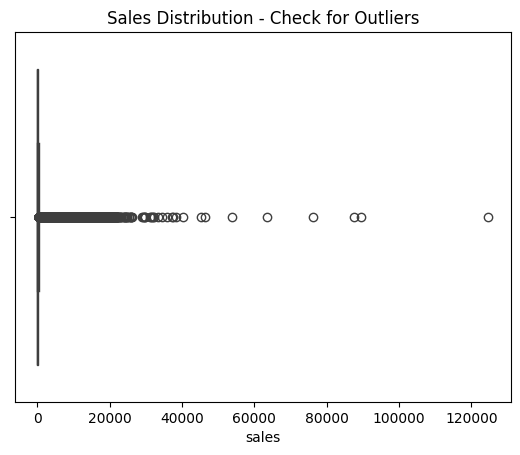

Number of outliers: 447105


In [2]:
# 1. Basic EDA
sns.boxplot(x=df['sales'])
plt.title('Sales Distribution - Check for Outliers')
plt.show()

# 2. Outlier detection using IQR
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['sales'] < lower) | (df['sales'] > upper)]
print(f"Number of outliers: {len(outliers)}")

# 3. Outlier handling Example: Capping
df['sales_capped'] = df['sales'].clip(lower=lower, upper=upper)

Visualizes and quantifies outliers.

Caps sales at calculated bounds to reduce impact of extreme values while retaining genuine seasonal spikes (like promotions).

In [3]:
# Date-based features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Lagged features
df['lag_7'] = df['sales_capped'].shift(7)
df['lag_14'] = df['sales_capped'].shift(14)
df['rolling_mean_7'] = df['sales_capped'].rolling(window=7).mean()

# Handle missing values (first 14 days have missing lags)
df.fillna(0, inplace=True)


Adds features that capture weekly/monthly patterns and recent sales history, boosting forecasting power.

In [4]:
# Aggregate sales
daily_sales = df.groupby('date')['sales_capped'].sum().reset_index()

Total sales gives a top-down business view

In [5]:
# Use aggregated or single series `series_df`
series_df = daily_sales  # or store1_item1

split_idx = int(len(series_df)*0.8)
train = series_df.iloc[:split_idx]
test = series_df.iloc[split_idx:]

print(train.shape, test.shape)


(1347, 2) (337, 2)


In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# SARIMAX can incorporate exogenous features, like day_of_week
exog_vars = ['day_of_week', 'month']
train_exog = train[exog_vars] if all(var in train.columns for var in exog_vars) else None
test_exog = test[exog_vars] if all(var in test.columns for var in exog_vars) else None

# Fit model (tune order/seasonality as needed)
model = SARIMAX(train['sales_capped'], order=(1,1,1), seasonal_order=(1,1,1,7), exog=train_exog)
model_fit = model.fit(disp=False)

# Forecast and evaluate
forecast = model_fit.forecast(steps=len(test), exog=test_exog)
test['forecast'] = forecast.values

rmse = np.sqrt(mean_squared_error(test['sales_capped'], test['forecast']))
print(f'RMSE: {rmse:.2f}')


RMSE: 28014.83


/tmp/ipython-input-4246965421.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = forecast.values


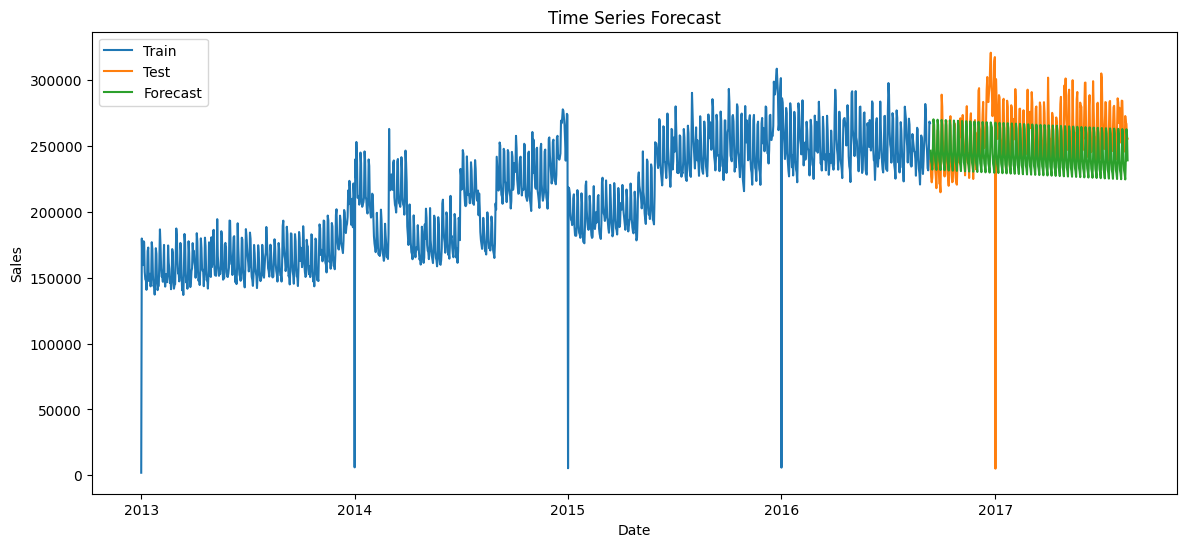

In [7]:
plt.figure(figsize=(14,6))
plt.plot(train['date'], train['sales_capped'], label='Train')
plt.plot(test['date'], test['sales_capped'], label='Test')
plt.plot(test['date'], test['forecast'], label='Forecast')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


Mean sales in test set: 258422.43
Median sales in test set: 256069.11
Standard deviation of sales: 24466.40
Root Mean Squared Error (RMSE): 28014.83
Mean Absolute Error (MAE): 19246.52
Mean Absolute Percentage Error (MAPE): 22.27%


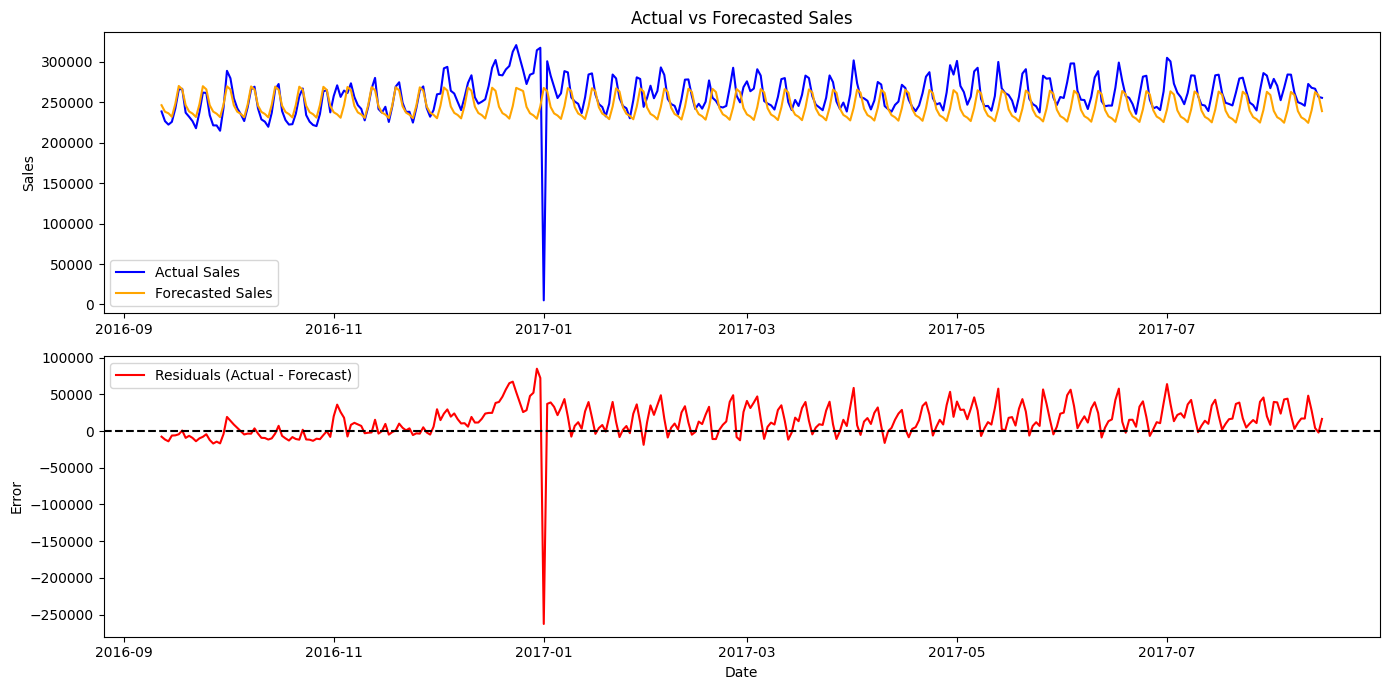


INTERPRETATION SUMMARY:
Decent accuracy: RMSE is about 10.84% of average sales. The model performs moderately well.
MAE and MAPE also suggest average absolute errors of 19246.52 units and 22.27% respectively.
Review the residuals plot for patterns — ideally residuals should be randomly dispersed without trends.


In [8]:
# 1. Basic sales statistics for context
mean_sales = test['sales_capped'].mean() if 'sales_capped' in test.columns else test['sales'].mean()
median_sales = test['sales_capped'].median() if 'sales_capped' in test.columns else test['sales'].median()
std_sales = test['sales_capped'].std() if 'sales_capped' in test.columns else test['sales'].std()

print(f"Mean sales in test set: {mean_sales:.2f}")
print(f"Median sales in test set: {median_sales:.2f}")
print(f"Standard deviation of sales: {std_sales:.2f}")

# 2. Calculate additional error metrics
from sklearn.metrics import mean_absolute_error

actuals = test['sales_capped'] if 'sales_capped' in test.columns else test['sales']
preds = test['forecast']

mae = mean_absolute_error(actuals, preds)
mape = np.mean(np.abs((actuals - preds) / actuals)) * 100

print(f"Root Mean Squared Error (RMSE): {np.sqrt(np.mean((actuals - preds)**2)):.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 3. Plot actual vs predicted and residuals
plt.figure(figsize=(14,7))

plt.subplot(2,1,1)
plt.plot(test['date'], actuals, label='Actual Sales', color='blue')
plt.plot(test['date'], preds, label='Forecasted Sales', color='orange')
plt.title('Actual vs Forecasted Sales')
plt.ylabel('Sales')
plt.legend()

plt.subplot(2,1,2)
residuals = actuals - preds
plt.plot(test['date'], residuals, label='Residuals (Actual - Forecast)', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Interpretative summary printout
error_ratio = np.sqrt(np.mean((actuals - preds)**2)) / mean_sales

print("\nINTERPRETATION SUMMARY:")
if error_ratio < 0.1:
    print(f"Great accuracy: RMSE is only {error_ratio:.2%} of average sales, indicating very close predictions.")
elif error_ratio < 0.25:
    print(f"Decent accuracy: RMSE is about {error_ratio:.2%} of average sales. The model performs moderately well.")
elif error_ratio < 0.5:
    print(f"Moderate accuracy: RMSE is {error_ratio:.2%} of average sales. Model needs improvement for business-critical decisions.")
else:
    print(f"Low accuracy: RMSE is {error_ratio:.2%} of average sales. Consider improving model, features, or data quality.")

print(f"MAE and MAPE also suggest average absolute errors of {mae:.2f} units and {mape:.2f}% respectively.")
print("Review the residuals plot for patterns — ideally residuals should be randomly dispersed without trends.")
